## Introduction

This project is inspired by my passion for cycling and the extensive biking data I've accumulated over the past year. After biking more than 3,000 kilometers, I became intrigued by the potential to extract insights from this wealth of data, recorded meticulously on Strava. Strava, a popular platform among athletes, provides rich metrics for every ride, which opens the door for data-driven analysis and predictive modeling.

The primary goal of this project is to develop a machine learning model capable of predicting the travel time on a segment. Accurately predicting travel time can be valuable for cyclists looking to plan their rides, set realistic goals, or measure progress over time. This project not only highlights the power of data in sports but also serves as a personal exploration of combining data science with my cycling hobby.

### What is a segment on Strava?

A segment on Strava is a specific portion of a route, defined by its start and end points, which athletes can traverse during their activities. Segments often include climbs, descents, or flat stretches and are typically used to compare performance across different attempts or among different athletes.

Each segment is associated with key metrics such as:

*   **Distance**: The total length of the segment.

*   **Elevation Gain and Loss**: The difference in altitude over the segment.

*   **Grade**: The steepness or incline of the segment (e.g., 5% average grade).

*   **Time**: The travel time recorded for an athlete to complete the segment.

Segments add a competitive and analytical dimension to cycling, as Strava ranks users based on their performance on these segments, creating leaderboards. For cyclists like me, who ride regularly and cover varied terrains, segments provide a structured way to evaluate and improve performance.

## Data retrieval from Strava API

To retrieve data with the Strava API, we follow these steps:

1.   **Application Registration**:
First, we create a developer application on Strava's API portal. This step provides us with a Client ID and Client Secret, which are necessary for accessing the API securely.

2.   **Authentication Using OAuth 2.0**: To ensure secure access, Strava uses the OAuth 2.0 protocol. This involves:
*   Redirecting the user to Strava’s authorization page to grant permissions to the application.
*   Exchanging the authorization code received for an access token, which is used to authenticate API requests.

3. **Data Retrieval**: With the access token, we can query Strava's API endpoints to fetch data:
*   **Activities**: Retrieve details of all recorded rides, including distance, elapsed time, and elevation gain.
*   **Segments**: Retrieve detailed information about specific segments, such as grade, elevation, and segment efforts.

In [1]:
import requests
import pandas as pd
from pandas import json_normalize
import json

# Access token to Strava API
ACCESS_TOKEN = 'your_access_token'
headers = {'Authorization': f'Bearer {ACCESS_TOKEN}'}

In [2]:
# Function to get all activities
def get_activities(page=1, per_page=30):
    url = 'https://www.strava.com/api/v3/athlete/activities'
    params = {'page': page, 'per_page': per_page}
    response = requests.get(url, headers=headers, params=params)
    return response.json()

In [3]:
# Function to get detailed activity with segment efforts
def get_activity_details(activity_id):
    url = f'https://www.strava.com/api/v3/activities/{activity_id}'
    params = {'include_all_efforts': 'true'}
    response = requests.get(url, headers=headers, params=params)
    return response.json()

In [4]:
# Retrieve all activities
activities = get_activities(per_page=35)
# activities

In [5]:
# Extract efforts from each activity
efforts = []
for activity in activities:
    activity_details = get_activity_details(activity['id'])
    for effort in activity_details.get('segment_efforts', []):
        efforts.append(effort)

In [6]:
# Store the efforts in a DataFrame and normalizing the 'segment' column
df = pd.DataFrame(efforts)
df_expanded = pd.json_normalize(df['segment'])
df_expanded = df_expanded.drop(columns=['distance'])
df = pd.concat([df, df_expanded], axis=1)
df = df.drop(columns=['segment'])

# Drop useless columns for our analysis
df = df.drop(columns=['id', 'activity', 'athlete', 'resource_state', 'start_date', 'start_date_local', 'device_watts',
                              'pr_rank', 'achievements', 'visibility', 'kom_rank', 'hidden', 'start_latlng', 'end_latlng', 'climb_category',
                              'private', 'hazardous', 'starred', 'country', 'state', 'elevation_profile', 'elevation_profiles',
                              'name', 'city', 'activity_type', 'moving_time'])

# Check if any NaN exists in the DataFrame
any_nan = df.isna().any().any()
print(f"Any NaN values: {any_nan}")

# Removing outliers from our data
# df = df[df['elapsed_time'] <= 2500]
df

Any NaN values: False


,elapsed_time,distance,start_index,end_index,average_grade,maximum_grade,elevation_high,elevation_low
0,42,216.40,195,237,-2.4,1.9,222.7,217.5
1,40,205.10,196,236,2.3,7.3,264.8,260.0
2,149,796.30,199,348,0.5,7.2,227.1,217.1
3,52,286.90,297,349,-0.8,6.5,226.6,219.9
4,2950,18494.80,646,3596,0.1,9.3,349.7,214.1
...,...,...,...,...,...,...,...,...
4249,174,976.30,8340,8503,0.6,5.0,207.2,200.6
4250,133,790.10,8406,8529,-0.4,7.0,227.6,219.8
4251,83,449.70,8430,8504,2.1,5.9,290.8,281.4
4252,59,311.14,8461,8510,2.8,7.8,186.6,178.0


## Data exploration

This section is dedicated to exploring and visualizing the dataset to uncover patterns, distributions, and relationships among the variables. This analysis helps us identify skewed distributions, potential outliers, and the relative importance of features like distance, elevation, and grade, which are critical for predicting travel time on a cycling segment.  

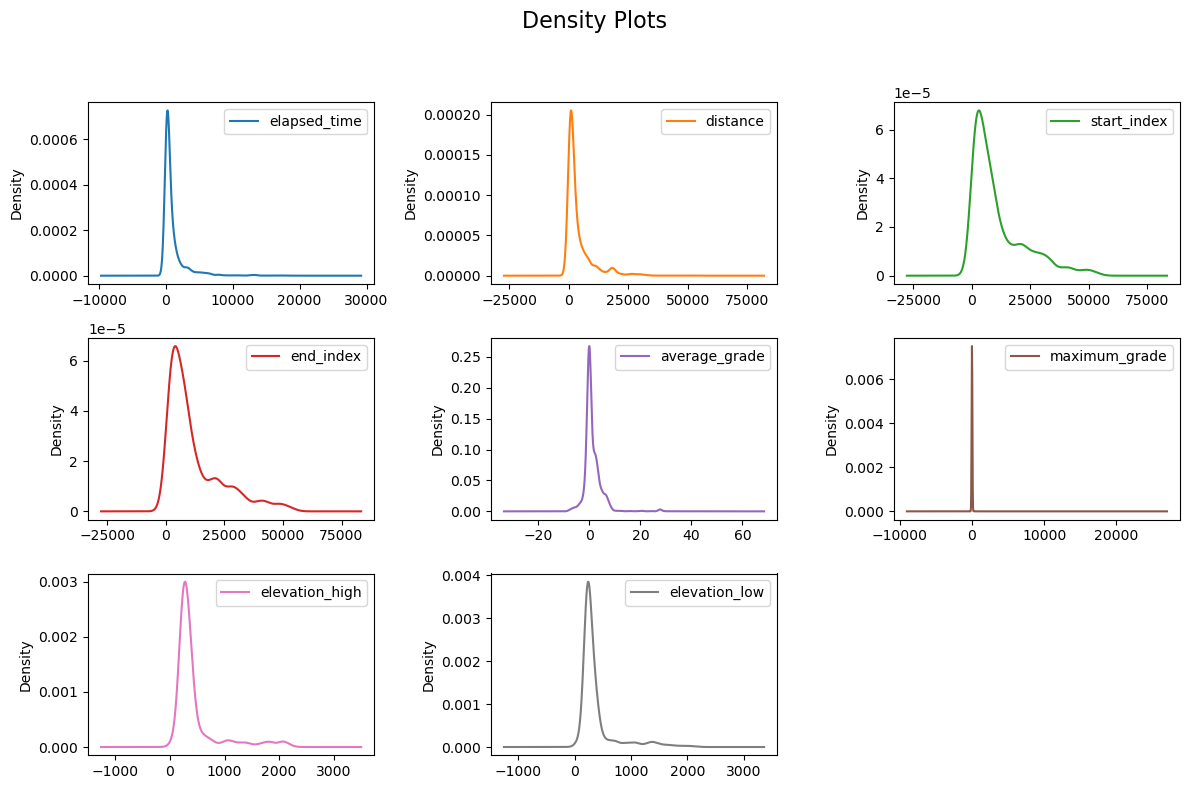

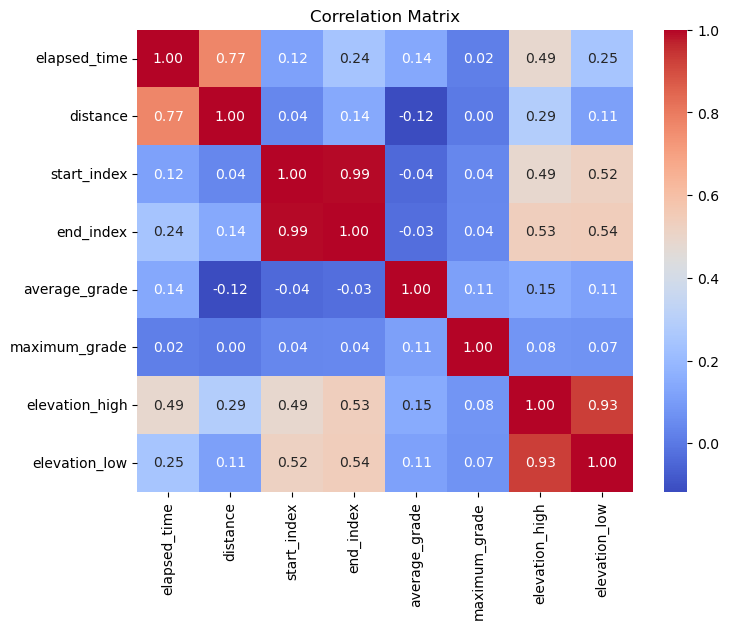

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_density_corrmat(df, no_density=False):
  if no_density == False:
    # Plot kernel density estimation (KDE) plots for all columns
    df.plot(kind='kde', subplots=True, layout=(3, 3), figsize=(12, 8), sharex=False)
    plt.suptitle("Density Plots", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

  # Compute the correlation matrix
  correlation_matrix = df.corr()

  # Plot the correlation matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
  plt.title('Correlation Matrix')
  plt.show()

plot_density_corrmat(df)

### Observations

1.   *elpased_time* and *distance* : Most segments are completed in a short time and cover short distances, which might make the prediction of longer times and distances challenging due to fewer examples.

2.   *average_grade* : Most segments are on flat terrain, so grade might not contribute much variability to the travel time predictions.

3. *elevation_high* and *elevation_low* : Both distributions are skewed, indicating that most segments occur at lower elevations, with a few outliers at higher altitudes. These features appear to be highly correlated and does not provide much independent information unless used as elevation differences.

4. *maximum_grade* : The distribution is heavily concentrated, likely indicating a few steep climbs or sharp inclines on some segments.

5. *start_index* and *end_index* : Both have very similar distributions with a wide range, likely tied to the structure of the dataset (e.g., segment indices).

### Possible improvements

*   Compute derived features like *elevation_gain* = *elevation_high* - *elevation_low* to represent the overall climb.

*   Compute the product of *distance* and *average_grade* to obtain a scaled estimate of the total vertical climb over the segment. While not an exact measure (due to averaging), it is proportional to the physical effort required to overcome the vertical climb.

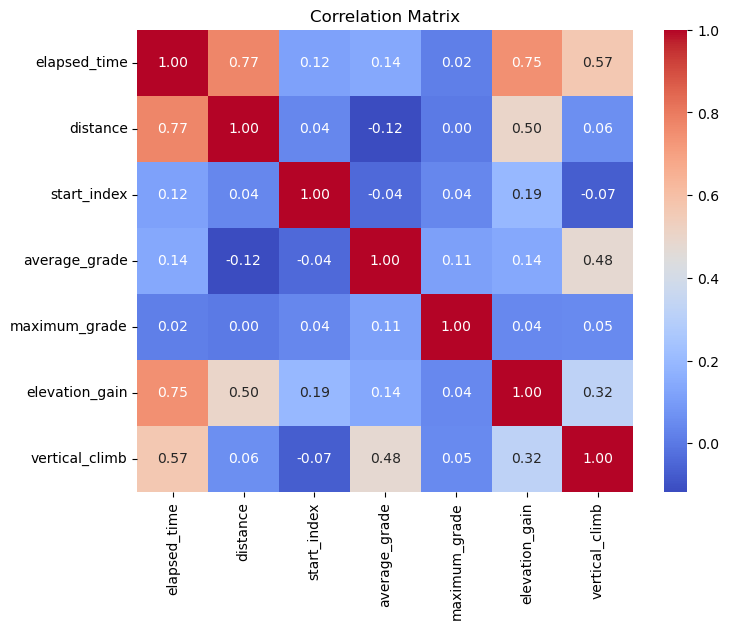

In [8]:
# Add the new column 'elevation_gain' and 'vertical_climb'
df['elevation_gain'] = df['elevation_high'] - df['elevation_low']
df['vertical_climb'] = df['distance'] * df['average_grade']

# Drop the original columns 'elevation_high', 'elevation_low' and also 'end_index'
df.drop(columns=['elevation_high', 'elevation_low', 'end_index'], inplace=True)

# Plot the new correlation matrix after feature engineering
plot_density_corrmat(df, no_density=True)

## Prediction models

Building on the insights from our data analysis and feature engineering, we now focus on predicting travel time *(elapsed_time)* using machine learning. This section evaluates three models: Linear Regression, Random Forest, and Gradient Boosting. By comparing their performance, we aim to determine the most effective approach for accurately predicting travel time based on the features we’ve engineered.

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

def train_model(PredictionModel, X_train, X_test, y_train, y_test):

  """
    Train and evaluate a prediction model using provided training and testing data.

    Parameters:
    ----------
    PredictionModel : A model class or function that initializes the prediction model.
    X_train : Feature data for training the model.
    X_test : Feature data for testing the model.
    y_train : Target values corresponding to `X_train` for training.
    y_test : Target values corresponding to `X_test` for evaluation.

    Returns:
    -------
    - y_pred : Predicted target values for the test set.
    - model : The trained model instance.
  """

  # Initialize and train the model
  model = PredictionModel()
  model.fit(X_train, y_train)

  # Predict on test set
  y_pred = model.predict(X_test)

  # Evaluate the model
  print("MAE:", mean_absolute_error(y_test, y_pred))
  print("RMSE:", root_mean_squared_error(y_test, y_pred))
  print("R² Score:", r2_score(y_test, y_pred))

  return y_pred, model

In [10]:
def plot_residuals(y_test, y_pred):
  """
    Plot residuals to evaluate the performance of a prediction model.

    Parameters:
    ----------
    y_test : Actual target values from the test set.
    y_pred : Predicted target values from the model.

    Displays:
    -------
    A residual plot showing:
    - The actual values (`y_test`) on the x-axis.
    - The residuals (`y_test - y_pred`) on the y-axis.
    - A horizontal red dashed line at 0 to indicate perfect predictions.
  """
  plt.scatter(y_test, y_test - y_pred)
  plt.axhline(0, color='red', linestyle='--')
  plt.title("Residual Plot")
  plt.xlabel("Actual Values")
  plt.ylabel("Residuals")
  plt.show()

By normalizing features like *distance*, *average_grade*, and *elevation_gain*, we reduce the risk of larger features overshadowing smaller ones. This ensures that the models we develop, Linear Regression, Random Forest, and Gradient Boosting, are not only accurate but also robust and generalizable to new data.

In [11]:
from sklearn.preprocessing import StandardScaler

# Features for prediction
X = df[['distance', 'average_grade', 'maximum_grade', 'start_index', 'elevation_gain', 'vertical_climb']]
y = df['elapsed_time']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### Linear Regression

In [13]:
# Train a linear regression model
y_pred_lr, lr_model = train_model(LinearRegression, X_train, X_test, y_train, y_test)

MAE: 239.12138471365927
RMSE: 499.4046467353524
R² Score: 0.9366098801323985


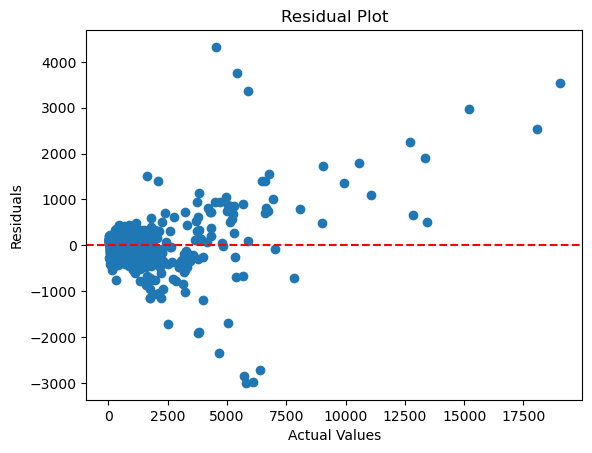

In [14]:
plot_residuals(y_test, y_pred_lr)

The model performs very well with high accuracy (low MAE and RMSE) and strong explanatory power (R² = 0.937). However, The model struggles with longer segments (*elapsed_time* > 7500 seconds), likely due to non-linear effects or unmodeled factors such as weather or fatigue.

### Random Forest

In [15]:
# Train a random forest model
y_pred_rf, rf_model = train_model(RandomForestRegressor, X_train, X_test, y_train, y_test)

MAE: 129.24532161043032
RMSE: 349.66361721139265
R² Score: 0.9689245585365656


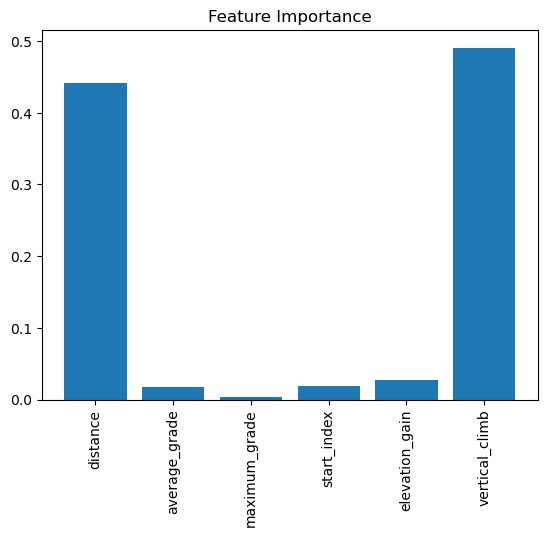

In [16]:
# Feature importance
feature_importances = rf_model.feature_importances_
plt.bar(X.columns, feature_importances)
plt.xticks(rotation=90)
plt.title("Feature Importance")
plt.show()

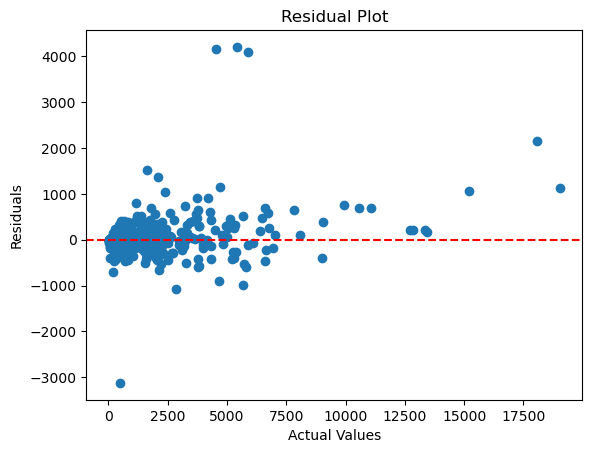

In [17]:
plot_residuals(y_test, y_pred_rf)

The Random Forest model reduces the average prediction error by nearly 46%, indicating better accuracy overall. RMSE is significantly lower for the Random Forest, showing that it handles larger errors better than the linear model. This highlights its robustness in minimizing the impact of outliers.

The feature importance analysis from Random Forest provides actionable insights, confirming that *distance* and *vertical_climb* are the key drivers of travel time.

The Random Forest explains 96.9% of the variance in elapsed_time, compared to 93.7% for Linear Regression. This improvement indicates that the Random Forest captures non-linear relationships in the data that the Linear Regression cannot.

### Gradient Boosting

In [18]:
y_pred_gb, gb_model = train_model(GradientBoostingRegressor, X_train, X_test, y_train, y_test)

MAE: 134.0513108930583
RMSE: 332.42335593972376
R² Score: 0.9719133802763871


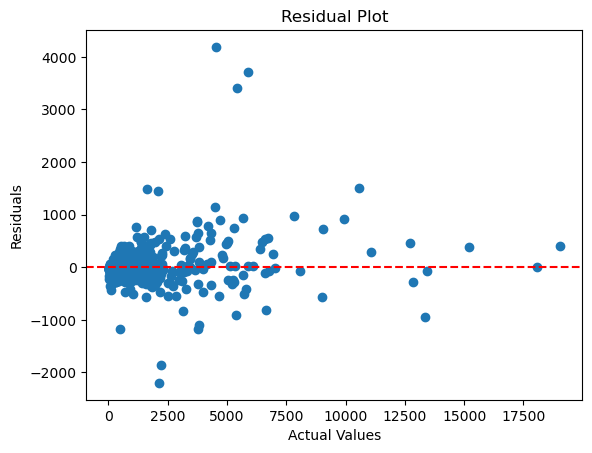

In [19]:
plot_residuals(y_test, y_pred_gb)

The Gradient Boosting model demonstrates excellent performance, surpassing both the Linear Regression and Random Forest models in some metrics. Here's a detailed comparison:

| Metric | Linear Regression | Random Forest | Gradient Boosting
| :- | -: | -: | -: |
| MAE | 239.12 | 129.27 | 133.97 |
| RMSE | 499.40 | 350.43 | 332.23 |
| R² Score | 0.937 | 0.969 | 0.972 |

Gradient Boosting excels in overall performance, offering the best balance between accuracy (low RMSE) and model fit (high R² score). While Random Forest has a marginally better MAE, Gradient Boosting handles larger errors and outliers more effectively, making it the preferred choice for this dataset. Compared to Linear Regression, both ensemble models (Random Forest and Gradient Boosting) significantly outperform due to their ability to model complex, non-linear relationships.

## Conclusion

This project demonstrates the power of data-driven approaches in enhancing cycling insights and planning. Starting with an analysis of over 3,000 kilometers of biking data, we extracted meaningful relationships between features like distance, elevation gain, and grade, and their impact on travel time. Through careful data preprocessing and feature engineering, such as introducing the *elevation_gain* variable, we prepared the dataset for robust modeling.

We developed and evaluated three machine learning models, Linear Regression, Random Forest, and Gradient Boosting, to predict *elapsed_time* for cycling segments. Each model was assessed using metrics like MAE, RMSE, and R² score, as well as residual analysis. The results highlighted the limitations of Linear Regression in capturing non-linear relationships, while ensemble models like Random Forest and Gradient Boosting proved highly effective.

Gradient Boosting emerged as the best-performing model, achieving an R² score of 0.972 and consistently handling complex patterns and outliers.

This project successfully demonstrates how personal interests, such as cycling, can intersect with data science to produce actionable predictions. The resulting models not only improve our understanding of the factors influencing travel time but also provide practical tools for planning and performance benchmarking. Future work could involve incorporating additional features like weather or rider-specific data.